<a href="https://colab.research.google.com/github/Karthik-GigaByte/Advanced-EDA-for-Genomic-Data-Analysis-Identifying-Genetic-Variations-Through-Visualization./blob/main/Advanced_EDA_for_Genomic_Data_Analysis_Identifying_Genetic_Variations_Through_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-allel --upgrade
!pip install cyvcf2 pysam

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import allel  # scikit-allel library for handling VCF files

##1. Function to Calculate the allele frequencies from genotype calls

Since the Allele Frequency(AF) data that was provided in the .vcf.gz file of YRI and CEU both contain the Standard AF, so we are going to caluclate the Allele frequencies for each position in the chromoses by using the "Genotype"

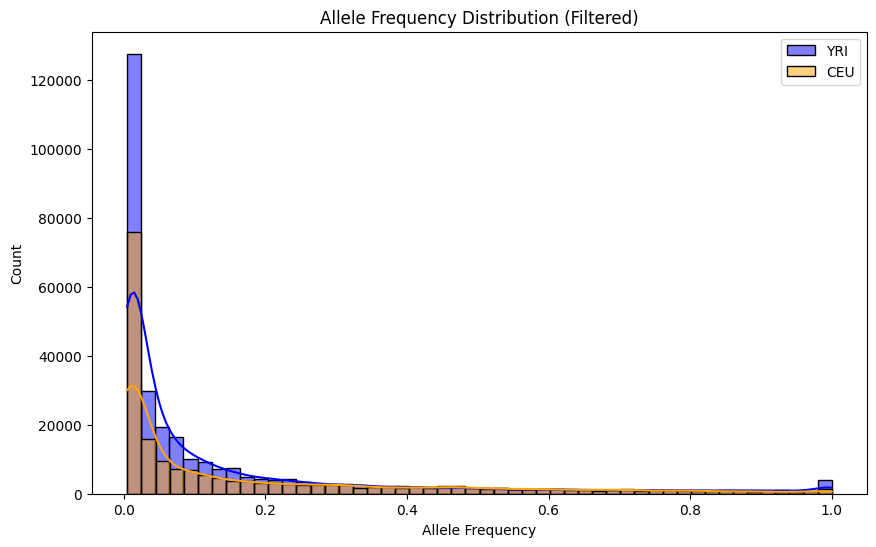

In [ ]:
# Function to calculate allele frequencies from genotype calls (for a chunk of data)
def calculate_allele_frequencies_chunk(chunk):
    positions = chunk.iloc[:, 1]  # SNP positions
    ref_alleles = chunk.iloc[:, 2]  # Reference alleles
    alt_alleles = chunk.iloc[:, 3]  # Alternate alleles
    genotypes = chunk.iloc[:, 4:]  # Genotype calls (for each individual)

    allele_freqs = []  # List to store allele frequencies

    # Iterate over each SNP to calculate the allele frequency
    for i in range(len(chunk)):
        gt_calls = genotypes.iloc[i].dropna()  # Get genotype calls for this SNP
        total_alleles = 0
        alt_count = 0

        # Loop through the genotypes for each individual at this SNP
        for gt in gt_calls:
            if gt == '0|0':  # Homozygous reference
                total_alleles += 2
            elif gt == '0|1' or gt == '1|0':  # Heterozygous
                total_alleles += 2
                alt_count += 1
            elif gt == '1|1':  # Homozygous alternate
                total_alleles += 2
                alt_count += 2

        # Calculate allele frequency (alt_count / total_alleles)
        af = alt_count / total_alleles if total_alleles > 0 else np.nan
        allele_freqs.append(af)

    return allele_freqs

# Function to process the file in chunks and calculate frequencies
def process_file_in_chunks(genotype_file, chunk_size=10000):
    allele_freqs = []
    for chunk in pd.read_csv(genotype_file, sep='\t', header=None, chunksize=chunk_size):
        # Calculate allele frequencies for this chunk of data
        af = calculate_allele_frequencies_chunk(chunk)
        allele_freqs.extend(af)  # Append results from this chunk

    return allele_freqs

# Calculate allele frequencies for YRI and CEU populations (using chunks)
yri_af = process_file_in_chunks('/content/drive/MyDrive/YRI_genotypes.txt')
ceu_af = process_file_in_chunks('/content/drive/MyDrive/CEU_genotypes.txt')

# # Plot allele frequency distributions
# plt.figure(figsize=(10, 6))

# # Plot distribution for YRI population
# sns.histplot(yri_af, bins=50, kde=True, label='YRI', color='blue')

# # Plot distribution for CEU population
# sns.histplot(ceu_af, bins=50, kde=True, label='CEU', color='orange')

# # Customize plot labels and title
# plt.title("Allele Frequency Distribution by Population")
# plt.xlabel("Allele Frequency")
# plt.ylabel("Count")
# plt.legend()

# # Display the plot
# plt.show()

yri_af_filtered = [af for af in yri_af if af > 0]
ceu_af_filtered = [af for af in ceu_af if af > 0]

plt.figure(figsize=(10, 6))
sns.histplot(yri_af_filtered, bins=50, kde=True, label='YRI', color='blue')
sns.histplot(ceu_af_filtered, bins=50, kde=True, label='CEU', color='orange')
plt.xlabel("Allele Frequency")
plt.ylabel("Count")
plt.title("Allele Frequency Distribution (Filtered)")
plt.legend()
plt.show()

In [ ]:
print(pd.Series(yri_af).describe())
print(pd.Series(ceu_af).describe())

count    1.059079e+06
mean     4.228379e-02
std      1.411909e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.672897e-03
max      1.000000e+00
dtype: float64
count    1.059079e+06
mean     3.306369e-02
std      1.264455e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
dtype: float64


#Understanding the Summary Statistics for Allele Frequency Data
The output of pd.Series(yri_af).describe() and pd.Series(ceu_af).describe() provides a statistical summary of allele frequencies (AF) for the YRI and CEU populations. Let’s break it down:
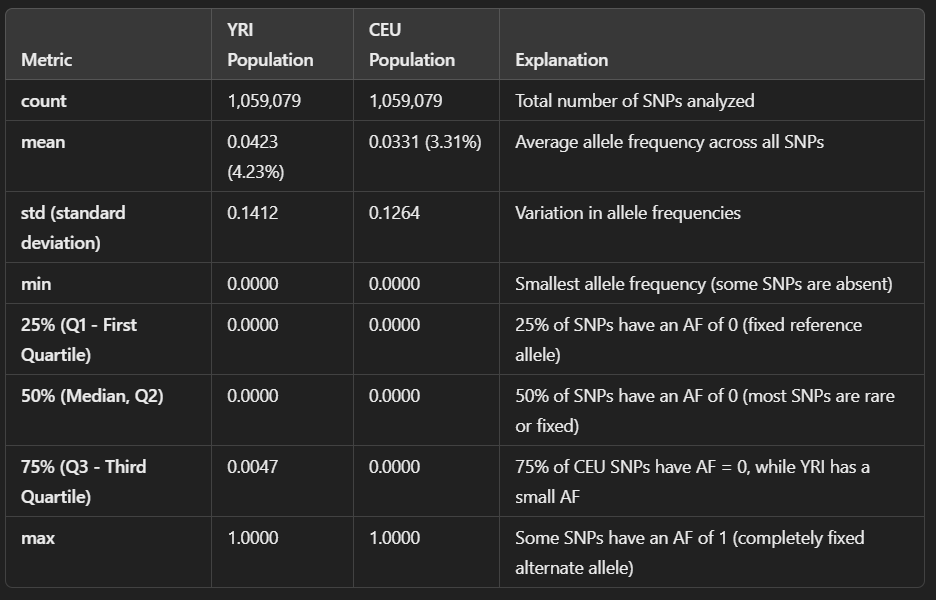

##2. Compare Population-Specific Genetic Variations
Objective : Identify genetic variations that are unique or significantly different between the two populations.
#Approach :
Perform a statistical test to compare allele frequencies between YRI and CEU populations. Common tests include:
Fisher’s Exact Test or Chi-Square Test for comparing genotype frequencies.
Fixation Index (Fst) to measure population differentiation.
Calculate p-values to determine whether observed differences are statistically significant.
Apply multiple testing correction (e.g., Bonferroni or Benjamini-Hochberg) to account for multiple comparisons.

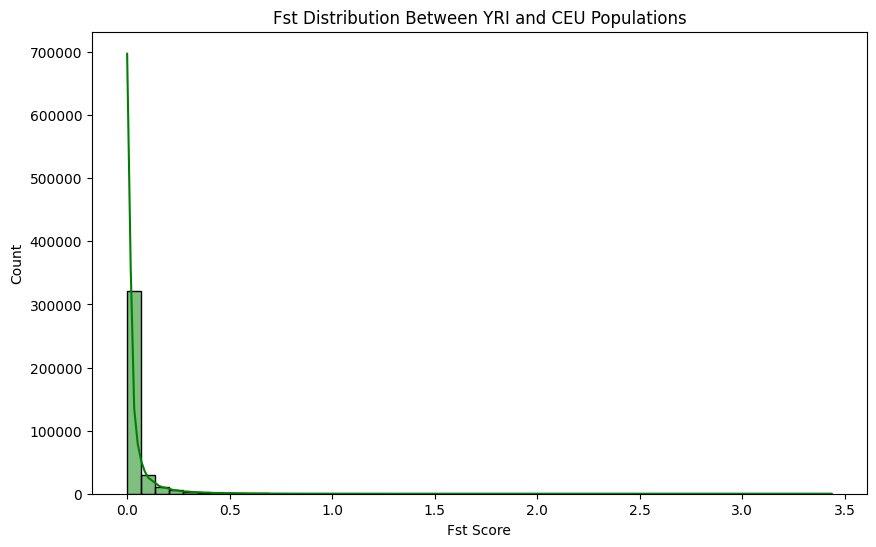

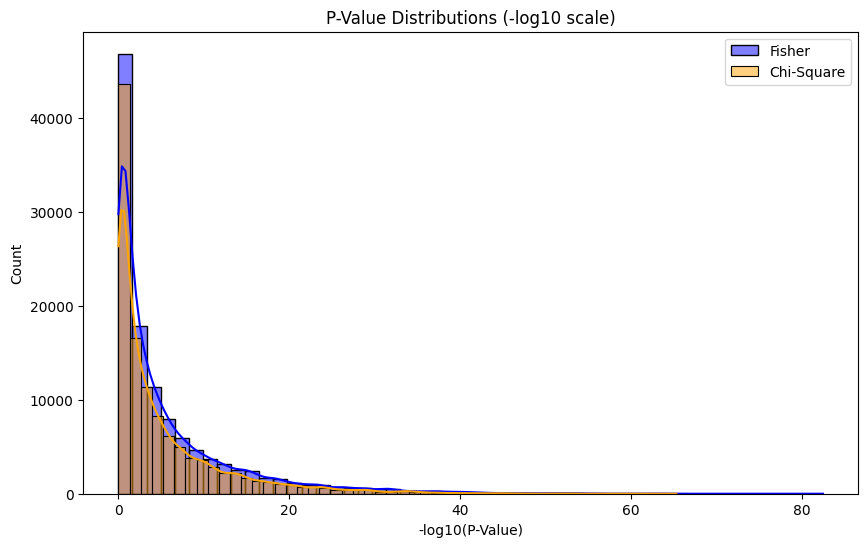

Significant SNPs saved to 'significant_snps.csv'


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate allele frequencies from genotype calls (for a chunk)
def calculate_allele_frequencies_chunk(chunk):
    genotypes = chunk.iloc[:, 4:]  # Genotype calls (for each individual)
    allele_freqs = []  # List to store allele frequencies
    for i in range(len(chunk)):
        gt_calls = genotypes.iloc[i].dropna()  # Get genotype calls for this SNP
        total_alleles = 0
        alt_count = 0
        for gt in gt_calls:
            if gt == '0|0':  # Homozygous reference
                total_alleles += 2
            elif gt == '0|1' or gt == '1|0':  # Heterozygous
                total_alleles += 2
                alt_count += 1
            elif gt == '1|1':  # Homozygous alternate
                total_alleles += 2
                alt_count += 2
        af = alt_count / total_alleles if total_alleles > 0 else np.nan
        allele_freqs.append(af)
    return allele_freqs

# Function to calculate Fst for a chunk
def calculate_fst_chunk(yri_af, ceu_af):
    fst_values = []
    for p1, p2 in zip(yri_af, ceu_af):
        h1 = 2 * p1 * (1 - p1)  # Heterozygosity in YRI
        h2 = 2 * p2 * (1 - p2)  # Heterozygosity in CEU
        ht = h1 + h2            # Total heterozygosity
        fst = (p1 - p2)**2 / ht if ht > 0 else np.nan
        fst_values.append(fst)
    return fst_values

# Function to perform Fisher's Exact Test for a chunk
def fishers_exact_test_chunk(yri_counts, ceu_counts):
    p_values = []
    for yri, ceu in zip(yri_counts, ceu_counts):
        if yri[0] == 0 or yri[1] == 0 or ceu[0] == 0 or ceu[1] == 0:
            p_values.append(np.nan)
            continue
        contingency_table = [[yri[0], yri[1]], [ceu[0], ceu[1]]]
        _, p_value = fisher_exact(contingency_table)
        p_values.append(p_value)
    return p_values

# Function to perform Chi-Square Test for a chunk
def chi_square_test_chunk(yri_counts, ceu_counts):
    p_values = []
    for yri, ceu in zip(yri_counts, ceu_counts):
        if yri[0] == 0 or yri[1] == 0 or ceu[0] == 0 or ceu[1] == 0:
            p_values.append(np.nan)
            continue
        contingency_table = [[yri[0], yri[1]], [ceu[0], ceu[1]]]
        try:
            _, p_value, _, _ = chi2_contingency(contingency_table)
        except ValueError:  # Handle cases where expected frequencies are zero
            p_value = np.nan
        p_values.append(p_value)
    return p_values

# Function to count alleles from genotype calls (for a chunk)
def count_alleles_chunk(genotypes):
    ref_counts = []
    alt_counts = []
    for gt_calls in genotypes:
        ref_count = 0
        alt_count = 0
        for gt in gt_calls:
            if gt == '0|0':  # Homozygous reference
                ref_count += 2
            elif gt == '0|1' or gt == '1|0':  # Heterozygous
                ref_count += 1
                alt_count += 1
            elif gt == '1|1':  # Homozygous alternate
                alt_count += 2
        ref_counts.append(ref_count)
        alt_counts.append(alt_count)
    return ref_counts, alt_counts

# Main processing function
def compare_populations(yri_file, ceu_file, chunk_size=10000):
    results = {
        'Fst': [],
        'Fisher_P_Value': [],
        'Chi_Square_P_Value': [],
        'CHROM': [],
        'POS': [],
        'REF': [],
        'ALT': []
    }

    # Process files in chunks
    for yri_chunk, ceu_chunk in zip(
        pd.read_csv(yri_file, sep='\t', header=None, chunksize=chunk_size),
        pd.read_csv(ceu_file, sep='\t', header=None, chunksize=chunk_size)
    ):
        # Extract relevant columns
        chrom = yri_chunk[0]
        pos = yri_chunk[1]
        ref = yri_chunk[2]
        alt = yri_chunk[3]

        # Extract genotype calls
        yri_genotypes = yri_chunk.iloc[:, 4:]
        ceu_genotypes = ceu_chunk.iloc[:, 4:]

        # Calculate allele frequencies for this chunk
        yri_af = calculate_allele_frequencies_chunk(yri_chunk)
        ceu_af = calculate_allele_frequencies_chunk(ceu_chunk)

        # Count alleles for this chunk
        yri_ref_counts, yri_alt_counts = count_alleles_chunk(yri_genotypes.values)
        ceu_ref_counts, ceu_alt_counts = count_alleles_chunk(ceu_genotypes.values)

        # Combine counts into a list of tuples
        yri_counts = list(zip(yri_ref_counts, yri_alt_counts))
        ceu_counts = list(zip(ceu_ref_counts, ceu_alt_counts))

        # Perform statistical tests for this chunk
        fst_scores = calculate_fst_chunk(yri_af, ceu_af)
        fisher_p_values = fishers_exact_test_chunk(yri_counts, ceu_counts)
        chi_square_p_values = chi_square_test_chunk(yri_counts, ceu_counts)

        # Append results
        results['Fst'].extend(fst_scores)
        results['Fisher_P_Value'].extend(fisher_p_values)
        results['Chi_Square_P_Value'].extend(chi_square_p_values)
        results['CHROM'].extend(chrom)
        results['POS'].extend(pos)
        results['REF'].extend(ref)
        results['ALT'].extend(alt)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Apply multiple testing correction (Benjamini-Hochberg)
    _, corrected_fisher_p_values, _, _ = multipletests(
        results_df['Fisher_P_Value'].dropna(), method='fdr_bh'
    )
    _, corrected_chi_square_p_values, _, _ = multipletests(
        results_df['Chi_Square_P_Value'].dropna(), method='fdr_bh'
    )
    results_df['Corrected_Fisher_P_Value'] = np.nan
    results_df['Corrected_Chi_Square_P_Value'] = np.nan
    results_df.loc[results_df['Fisher_P_Value'].notna(), 'Corrected_Fisher_P_Value'] = corrected_fisher_p_values
    results_df.loc[results_df['Chi_Square_P_Value'].notna(), 'Corrected_Chi_Square_P_Value'] = corrected_chi_square_p_values

    # Filter significant SNPs
    significant_snps = results_df[
        (results_df['Fst'] > 0.2) |
        (results_df['Corrected_Fisher_P_Value'] < 0.05) |
        (results_df['Corrected_Chi_Square_P_Value'] < 0.05)
    ]

    # Save significant SNPs to a file
    significant_snps.to_csv('significant_snps.csv', index=False)

    # Plot Fst distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['Fst'].dropna(), bins=50, kde=True, color='green')
    plt.title("Fst Distribution Between YRI and CEU Populations")
    plt.xlabel("Fst Score")
    plt.ylabel("Count")
    plt.show()

    # Plot p-value distributions
    plt.figure(figsize=(10, 6))
    sns.histplot(-np.log10(results_df['Corrected_Fisher_P_Value'].dropna()), bins=50, kde=True, color='blue', label='Fisher')
    sns.histplot(-np.log10(results_df['Corrected_Chi_Square_P_Value'].dropna()), bins=50, kde=True, color='orange', label='Chi-Square')
    plt.title("P-Value Distributions (-log10 scale)")
    plt.xlabel("-log10(P-Value)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    print("Significant SNPs saved to 'significant_snps.csv'")

# Run the comparison
compare_populations('/content/drive/MyDrive/YRI_genotypes.txt', '/content/drive/MyDrive/CEU_genotypes.txt', chunk_size=10000)

This image represents the distribution of Fst scores between the YRI (Yoruba in Ibadan, Nigeria) and CEU (Utah residents with Northern and Western European ancestry) populations. Here's a breakdown of what this plot indicates:

1. What is Fst?
Fst (Fixation Index) measures genetic differentiation between populations.
Values range from 0 to 1 (or sometimes higher due to estimation methods).
Fst ≈ 0 → Little to no differentiation (populations share similar allele frequencies).
Fst > 0.2 → Moderate genetic differentiation.
Fst > 0.3-0.5 → Strong genetic differentiation.
2. Interpretation of the Plot
Most Fst scores are very close to 0, meaning that the majority of SNPs have similar allele frequencies in both populations.
A sharp peak near 0 suggests that most genetic variants are shared between CEU and YRI.
The long tail to the right indicates a few SNPs with higher Fst scores, meaning they show significant population differentiation.
The density curve (green line) follows the histogram, reinforcing that extreme differentiation (Fst > 0.5) is rare.

##3. Identify Population-Specific SNPs
Objective : Highlight SNPs that are highly differentiated between the two populations.
#Approach :
Use a threshold (e.g., Fst > 0.2 or p-value < 0.05 after correction) to identify SNPs with significant differentiation.
Annotate these SNPs using tools like ANNOVAR or Ensembl Variant Effect Predictor (VEP) to determine their functional impact (e.g., coding vs. non-coding regions, synonymous vs. non-synonymous mutations).
Example Workflow :

Export the list of significant SNPs to a file.
Use an annotation tool to map SNPs to genes and predict their biological relevance.

In [ ]:
import pandas as pd

# Define file paths
input_file = "significant_snps.csv"
output_file = "population_specific_snps.csv"
chunk_size = 1000  # Adjust for memory efficiency

# Define significance thresholds
FST_THRESHOLD = 0.2
P_VALUE_THRESHOLD = 0.05

# Columns to check for missing values
columns_to_check = ['Fst', 'Corrected_Fisher_P_Value', 'Corrected_Chi_Square_P_Value']

try:
    # Open output file and write headers
    with open(output_file, 'w') as out_file:
        first_chunk = True  # Flag to write headers only once

        # Process in chunks
        for chunk in pd.read_csv(input_file, chunksize=chunk_size):
            # Ensure required columns are present before processing
            required_columns = ['CHROM', 'POS', 'REF', 'ALT']
            if not all(col in chunk.columns for col in required_columns):
                raise ValueError("Input file must contain CHROM, POS, REF, ALT columns.")

            # Drop rows where all key columns are missing
            chunk.dropna(subset=columns_to_check, how='all', inplace=True)

            # Filter SNPs based on thresholds
            filtered_snps = chunk[
                (chunk['Fst'] > FST_THRESHOLD) &
                ((chunk['Corrected_Fisher_P_Value'] < P_VALUE_THRESHOLD) |
                 (chunk['Corrected_Chi_Square_P_Value'] < P_VALUE_THRESHOLD))
            ]

            # Append results to the output file
            if not filtered_snps.empty:
                filtered_snps.to_csv(out_file, mode='a', index=False, header=first_chunk)
                first_chunk = False  # Ensure headers are written only once

    print(f"Filtered SNPs saved to {output_file}")
except Exception as e:
    print(f"An error occurred: {e}")

Filtered SNPs saved to population_specific_snps.csv


##4. Variant Effect Predictor (VEP)
After identifying the population-specific SNPs (Single Nucleotide Polymorphisms) using the provided code, the next step would be to annotate these variants with their potential functional effects on genes and transcripts. This is where Variant Effect Predictor (VEP) comes into play.

What is VEP?
Variant Effect Predictor (VEP) is a tool developed by Ensembl that analyzes genomic variants (like SNPs) and predicts their effects on genes. It provides detailed information about each variant's impact on gene function, including:

Transcript Consequences : The effect of the variant on specific transcripts (e.g., missense, nonsense, synonymous, etc.).
Protein Changes : Amino acid changes resulting from non-synonymous coding variants.
Regulatory Effects : Impact on regulatory regions like promoters or enhancers.
Conservation Scores : How conserved the affected region is across species.
Population Frequencies : Frequency of the variant in various populations.
Clinical Significance : Known clinical significance of the variant if available.
Steps to Use VEP for Annotated Variants
Prepare Input File :
Convert your list of significant SNPs into a format compatible with VEP (typically a VCF file).
Run VEP :
Use the VEP command-line tool or web interface to annotate your variants. Here’s an example of running VEP via the command line:

In [ ]:
import csv

# Input CSV file containing SNP data
input_csv = 'population_specific_snps.csv'
output_vcf = 'population_specific_snps.vcf'

# Read the CSV file
with open(input_csv, mode='r') as infile:
    reader = csv.DictReader(infile)
    snps = list(reader)

# Write the VCF file
with open(output_vcf, mode='w', newline='') as outfile:
    outfile.write("##fileformat=VCFv4.2\n")
    # Adding custom INFO fields
    outfile.write("##INFO=<ID=FST,Number=1,Type=Float,Description=\"Fixation Index\">\n")
    outfile.write("##INFO=<ID=PVAL,Number=1,Type=Float,Description=\"P-Value\">\n")
    outfile.write("##FORMAT=<ID=GT,Number=1,Type=String,Description=\"Genotype\">\n")
    outfile.write("#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tSample\n")

    for snp in snps:
        # Constructing INFO field with FST and PVAL
        info_fields = [
            f"FST={snp['Fst']}",
            f"PVAL={snp['Fisher_P_Value']}"  # Assuming 'Fisher_P_Value' is your PVAL equivalent
        ]
        info_str = ";".join(info_fields)
        # Writing the line with the constructed INFO field
        line = f"{snp['CHROM']}\t{snp['POS']}\t.\t{snp['REF']}\t{snp['ALT']}\t.\t.\t{info_str}\tGT\t0/1\n"
        outfile.write(line)

print(f"VCF file '{output_vcf}' has been created.")

VCF file 'population_specific_snps.vcf' has been created.


##**5. Steps to Implement SNP Annotation in Your Project:**
1.Read the population_specific_snps.csv file in chunks to handle large data efficiently.

2.Send requests for each SNP (chromosome, position, reference allele, alternate allele).

3.Store the results in a new CSV file with the annotation details

Summary
SNP annotation helps you understand the biological meaning of a genetic variant. It tells you:

🔹 Where the SNP is located (in a gene, in a coding region, or non-coding region)
🔹 What effect it has (harmless, disease-causing, or affecting protein function)
🔹 If it’s known (previously studied in databases like ClinVar or dbSNP)

In [ ]:
pip install requests pandas

In [ ]:
import requests
import json
import pandas as pd
import time
from typing import List, Optional
from pathlib import Path

def annotate_variants(variants: List[str], retries: int = 3, delay: float = 1.0) -> Optional[List[dict]]:
    """
    Annotate a list of variants using Ensembl VEP API with HGVS notation.

    Args:
        variants: List of HGVS formatted variants (e.g., "22:g.11067380G>A").
        retries: Number of retry attempts for failed requests.
        delay: Delay between retries in seconds.

    Returns:
        List of annotations or None if the request fails.
    """
    server = "https://rest.ensembl.org"
    endpoint = "/vep/human/hgvs"
    headers = {"Content-Type": "application/json", "Accept": "application/json"}
    payload = {"hgvs_notations": variants}

    for attempt in range(retries):
        try:
            response = requests.post(server + endpoint, headers=headers, data=json.dumps(payload), timeout=10)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP Error (Attempt {attempt + 1}/{retries}): {http_err}")
            print(f"Response: {response.text}")
        except requests.exceptions.RequestException as req_err:
            print(f"Request Error (Attempt {attempt + 1}/{retries}): {req_err}")
        if attempt < retries - 1:
            time.sleep(delay)
    print(f"Failed to annotate variants after {retries} attempts.")
    return None

def format_variant(chrom: str, pos: str, ref: str, alt: str) -> Optional[str]:
    """
    Format a variant into HGVS notation.

    Args:
        chrom: Chromosome (e.g., "22").
        pos: Position (e.g., "11067380").
        ref: Reference allele (e.g., "G").
        alt: Alternate allele (e.g., "A").

    Returns:
        HGVS string or None if formatting fails.
    """
    try:
        chrom = chrom.replace("chr", "")  # Remove "chr" prefix
        pos_int = int(pos)  # Ensure position is numeric
        return f"{chrom}:g.{pos_int}{ref}>{alt}"
    except (ValueError, TypeError) as e:
        print(f"Invalid variant data - Chrom: {chrom}, Pos: {pos}, Ref: {ref}, Alt: {alt}. Error: {e}")
        return None

def process_variants(input_file: str, output_file: str, chunk_size: int = 50) -> None:
    """
    Process variants from a CSV file and annotate using Ensembl VEP API.

    Args:
        input_file: Path to input CSV file.
        output_file: Path to output CSV file.
        chunk_size: Number of variants per API request.
    """
    # Validate input file existence
    if not Path(input_file).is_file():
        raise FileNotFoundError(f"Input file not found: {input_file}")

    required_columns = {"CHROM", "POS", "REF", "ALT"}
    all_annotations = []

    # Process CSV in chunks
    for chunk in pd.read_csv(input_file, chunksize=chunk_size, dtype=str, usecols=required_columns):
        # Verify required columns
        if not required_columns.issubset(chunk.columns):
            raise ValueError(f"CSV must contain columns: {required_columns}")

        # Drop rows with missing values in required columns
        chunk = chunk.dropna(subset=required_columns)

        # Format variants into HGVS notation
        variants = [
            format_variant(row["CHROM"], row["POS"], row["REF"], row["ALT"])
            for _, row in chunk.iterrows()
        ]
        # Filter out None values from invalid variants
        variants = [v for v in variants if v is not None]

        if not variants:
            print("No valid variants in this chunk. Skipping...")
            continue

        # Annotate variants
        annotations = annotate_variants(variants)
        if annotations:
            all_annotations.extend(annotations)

        # Rate limiting
        time.sleep(1)

    # Save results
    if all_annotations:
        df = pd.json_normalize(all_annotations)
        df.to_csv(output_file, index=False)
        print(f"Annotated {len(all_annotations)} variants saved to {output_file}")
    else:
        print("No annotations retrieved.")

def main():
    """Main function to run the variant annotation process."""
    input_file = "/content/drive/MyDrive/population_specific_snps.csv"
    output_file = "annotated_snps.csv"

    try:
        process_variants(input_file, output_file, chunk_size=50)
    except Exception as e:
        print(f"Error in processing: {e}")

if __name__ == "__main__":
    main()

Annotated 10862 variants saved to annotated_snps.csv


##6. Manhattan Plot Visualization

A Manhattan plot is a widely used visualization in genomics to display the significance of SNPs across the genome.

    X-axis (Genomic Position):
        Represents SNP positions along the genome.
        Each SNP is plotted according to its chromosomal position.
        Chromosomes are color-coded for easy distinction.

    Y-axis (-log10(P-Value)):
        The higher the value, the more statistically significant the SNP.
        P-values indicate how strongly an SNP is associated with a genetic trait.
        We take -log10(P-value) to make small P-values (which indicate significance) more visible.
            Example: A P-value of 0.0001 becomes 4 on this scale.

    Each point represents an SNP.

    Blue Dashed Line (Significance Threshold at P=0.05):
      Any SNP above this line is statistically significant.
      These SNPs may indicate genetic variants that are important in population differentiation.

    Clusters of high SNPs in a region:
      Suggests genetic variants that might be important for selection or associated with traits.
    Scattered dots below the threshold:
      Most SNPs are not significant in distinguishing populations.
    SNPs above the threshold:
      These SNPs are likely under selection or associated with important genetic differences between populations.

  The significance threshold (p = 0.05) is a cutoff used to determine whether a result is statistically significant.

    If p < 0.05, the SNP is considered significant (unlikely due to random chance).
    
    If p > 0.05, the SNP is not significant (likely due to chance).

In the Manhattan plot, SNPs above the blue dashed line (−log⁡10(0.05)=1.3−log10​(0.05)=1.3) are statistically significant, meaning they might have an important role in genetic differentiation.


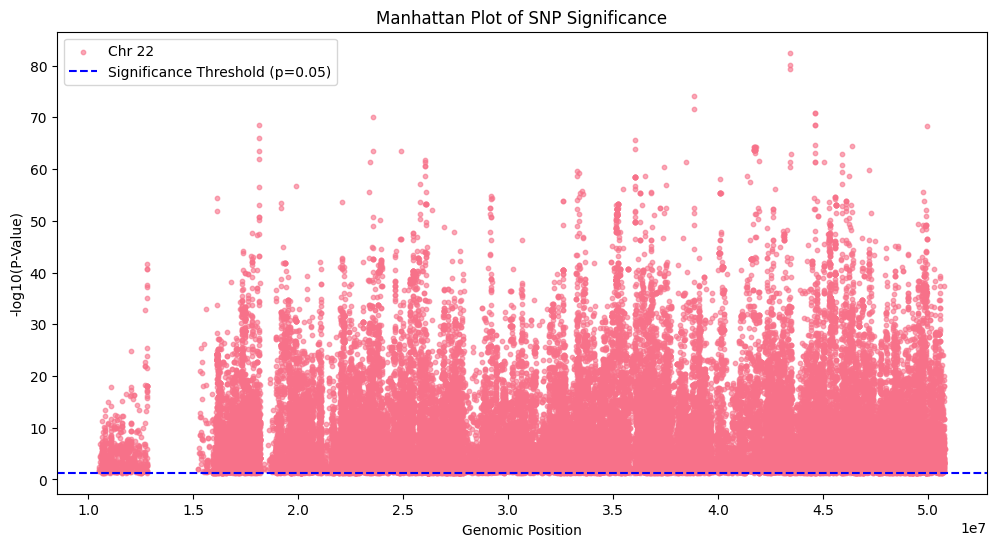

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the CSV file
file_path = "/content/drive/MyDrive/significant_snps.csv"
df = pd.read_csv(file_path)

# Remove NaN P-values and copy DataFrame
df_clean = df.dropna(subset=['Corrected_Fisher_P_Value']).copy()

# Convert P-value to -log10(P) for visualization
df_clean['-log10P'] = -np.log10(df_clean['Corrected_Fisher_P_Value'])

# Convert chromosome to categorical and sort
df_clean['CHROM'] = df_clean['CHROM'].astype(str)
df_clean = df_clean.sort_values(['CHROM', 'POS'])

# Assign alternating colors to chromosomes
chromosomes = df_clean['CHROM'].unique()
palette = sns.color_palette("husl", len(chromosomes))

plt.figure(figsize=(12, 6))

# Plot each chromosome separately for alternating colors
for i, chrom in enumerate(chromosomes):
    subset = df_clean[df_clean['CHROM'] == chrom]
    plt.scatter(subset['POS'], subset['-log10P'], color=palette[i % len(palette)], alpha=0.6, s=10, label=f'Chr {chrom}' if i < 5 else None)

# Add significance threshold line
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='dashed', label='Significance Threshold (p=0.05)')

plt.xlabel("Genomic Position")
plt.ylabel("-log10(P-Value)")
plt.title("Manhattan Plot of SNP Significance")

plt.legend()
plt.show()


##7. Fst Distribution (Histogram)

This shows how genetic differentiation (Fst values) is distributed among SNPs. A higher Fst indicates stronger genetic differentiation between populations.

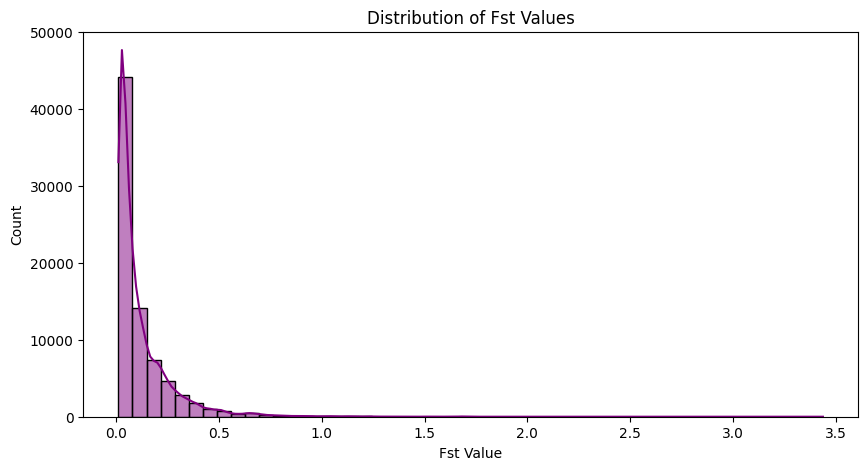

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Fst'], bins=50, kde=True, color='purple')

plt.xlabel("Fst Value")
plt.ylabel("Count")
plt.title("Distribution of Fst Values")
plt.show()


##8. Scatter Plot: Fst vs. -log10(P-Value)

This shows whether higher genetic differentiation (Fst) is linked to statistical significance.

SNPs with high Fst and significant P-values (upper right corner) suggest genetic variants important for population differentiation.
SNPs below the threshold are not statistically significant, meaning their Fst differences could be random.

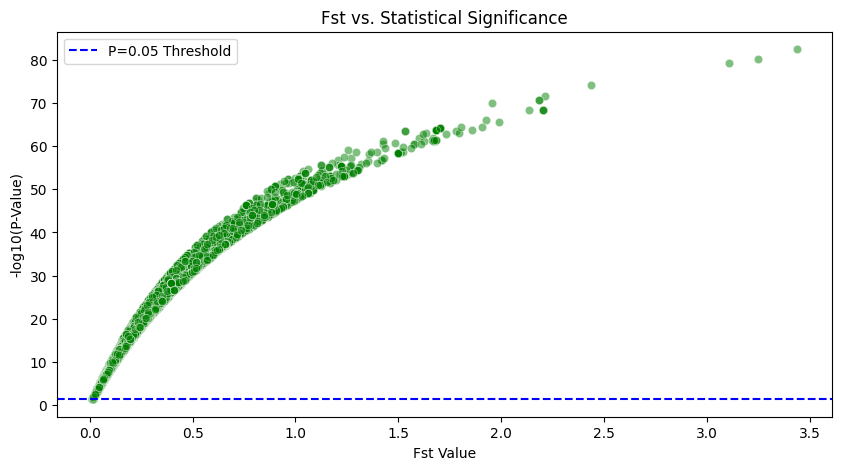

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Fst'], y=-np.log10(df['Corrected_Fisher_P_Value']), alpha=0.5, color='green')

plt.xlabel("Fst Value")
plt.ylabel("-log10(P-Value)")
plt.title("Fst vs. Statistical Significance")
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='dashed', label="P=0.05 Threshold")
plt.legend()
plt.show()

##9. Significant snps with populations

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate allele frequencies from genotype calls (for a chunk)
def calculate_allele_frequencies_chunk(chunk):
    genotypes = chunk.iloc[:, 4:]  # Genotype calls (for each individual)
    allele_freqs = []  # List to store allele frequencies
    for i in range(len(chunk)):
        gt_calls = genotypes.iloc[i].dropna()  # Get genotype calls for this SNP
        total_alleles = 0
        alt_count = 0
        for gt in gt_calls:
            if gt == '0|0':  # Homozygous reference
                total_alleles += 2
            elif gt in ['0|1', '1|0']:  # Heterozygous
                total_alleles += 2
                alt_count += 1
            elif gt == '1|1':  # Homozygous alternate
                total_alleles += 2
                alt_count += 2
        af = alt_count / total_alleles if total_alleles > 0 else np.nan
        allele_freqs.append(af)
    return allele_freqs

# Function to calculate Fst for a chunk
def calculate_fst_chunk(yri_af, ceu_af):
    fst_values = []
    for p1, p2 in zip(yri_af, ceu_af):
        h1 = 2 * p1 * (1 - p1)  # Heterozygosity in YRI
        h2 = 2 * p2 * (1 - p2)  # Heterozygosity in CEU
        ht = h1 + h2            # Total heterozygosity
        fst = (p1 - p2) ** 2 / ht if ht > 0 else np.nan
        fst_values.append(fst)
    return fst_values

# Function to perform Fisher's Exact Test for a chunk
def fishers_exact_test_chunk(yri_counts, ceu_counts):
    p_values = []
    for yri, ceu in zip(yri_counts, ceu_counts):
        if yri[0] == 0 or yri[1] == 0 or ceu[0] == 0 or ceu[1] == 0:
            p_values.append(np.nan)
            continue
        contingency_table = [[yri[0], yri[1]], [ceu[0], ceu[1]]]
        _, p_value = fisher_exact(contingency_table)
        p_values.append(p_value)
    return p_values

# Function to perform Chi-Square Test for a chunk
def chi_square_test_chunk(yri_counts, ceu_counts):
    p_values = []
    for yri, ceu in zip(yri_counts, ceu_counts):
        if yri[0] == 0 or yri[1] == 0 or ceu[0] == 0 or ceu[1] == 0:
            p_values.append(np.nan)
            continue
        contingency_table = [[yri[0], yri[1]], [ceu[0], ceu[1]]]
        try:
            _, p_value, _, _ = chi2_contingency(contingency_table)
        except ValueError:
            p_value = np.nan
        p_values.append(p_value)
    return p_values

# Function to count alleles from genotype calls (for a chunk)
def count_alleles_chunk(genotypes):
    ref_counts = []
    alt_counts = []
    for gt_calls in genotypes:
        ref_count = 0
        alt_count = 0
        for gt in gt_calls:
            if gt == '0|0':  # Homozygous reference
                ref_count += 2
            elif gt in ['0|1', '1|0']:  # Heterozygous
                ref_count += 1
                alt_count += 1
            elif gt == '1|1':  # Homozygous alternate
                alt_count += 2
        ref_counts.append(ref_count)
        alt_counts.append(alt_count)
    return ref_counts, alt_counts

# Main processing function
def compare_populations(yri_file, ceu_file, chunk_size=10000):
    results = {
        'CHROM': [],
        'POS': [],
        'REF': [],
        'ALT': [],
        'YRI_AF': [],  # Store YRI allele frequencies
        'CEU_AF': [],  # Store CEU allele frequencies
        'Fst': [],
        'Fisher_P_Value': [],
        'Chi_Square_P_Value': []
    }

    for yri_chunk, ceu_chunk in zip(
        pd.read_csv(yri_file, sep='\t', header=None, chunksize=chunk_size),
        pd.read_csv(ceu_file, sep='\t', header=None, chunksize=chunk_size)
    ):
        chrom = yri_chunk[0]
        pos = yri_chunk[1]
        ref = yri_chunk[2]
        alt = yri_chunk[3]

        yri_genotypes = yri_chunk.iloc[:, 4:]
        ceu_genotypes = ceu_chunk.iloc[:, 4:]

        yri_af = calculate_allele_frequencies_chunk(yri_chunk)
        ceu_af = calculate_allele_frequencies_chunk(ceu_chunk)

        yri_ref_counts, yri_alt_counts = count_alleles_chunk(yri_genotypes.values)
        ceu_ref_counts, ceu_alt_counts = count_alleles_chunk(ceu_genotypes.values)

        yri_counts = list(zip(yri_ref_counts, yri_alt_counts))
        ceu_counts = list(zip(ceu_ref_counts, ceu_alt_counts))

        fst_scores = calculate_fst_chunk(yri_af, ceu_af)
        fisher_p_values = fishers_exact_test_chunk(yri_counts, ceu_counts)
        chi_square_p_values = chi_square_test_chunk(yri_counts, ceu_counts)

        results['CHROM'].extend(chrom)
        results['POS'].extend(pos)
        results['REF'].extend(ref)
        results['ALT'].extend(alt)
        results['YRI_AF'].extend(yri_af)
        results['CEU_AF'].extend(ceu_af)
        results['Fst'].extend(fst_scores)
        results['Fisher_P_Value'].extend(fisher_p_values)
        results['Chi_Square_P_Value'].extend(chi_square_p_values)

    results_df = pd.DataFrame(results)

    _, corrected_fisher_p_values, _, _ = multipletests(results_df['Fisher_P_Value'].dropna(), method='fdr_bh')
    _, corrected_chi_square_p_values, _, _ = multipletests(results_df['Chi_Square_P_Value'].dropna(), method='fdr_bh')

    results_df['Corrected_Fisher_P_Value'] = np.nan
    results_df['Corrected_Chi_Square_P_Value'] = np.nan
    results_df.loc[results_df['Fisher_P_Value'].notna(), 'Corrected_Fisher_P_Value'] = corrected_fisher_p_values
    results_df.loc[results_df['Chi_Square_P_Value'].notna(), 'Corrected_Chi_Square_P_Value'] = corrected_chi_square_p_values

    significant_snps = results_df[
        (results_df['Fst'] > 0.2) |
        (results_df['Corrected_Fisher_P_Value'] < 0.05) |
        (results_df['Corrected_Chi_Square_P_Value'] < 0.05)
    ]

    significant_snps.to_csv('significant_snps_with_populations.csv', index=False)

    print("Updated file saved as 'significant_snps_with_populations.csv'")

# Run the comparison
compare_populations('/content/drive/MyDrive/YRI_genotypes.txt', '/content/drive/MyDrive/CEU_genotypes.txt', chunk_size=10000)


Updated file saved as 'significant_snps_with_populations.csv'


##10. Allele Frequency Comparison: YRI vs. CEU

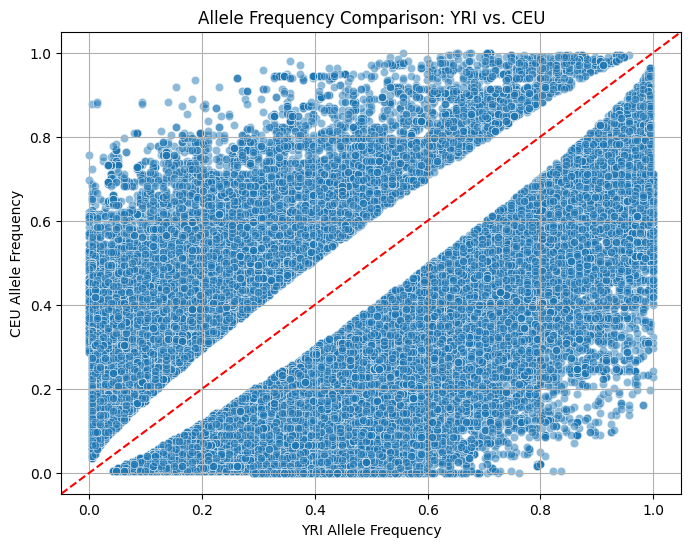

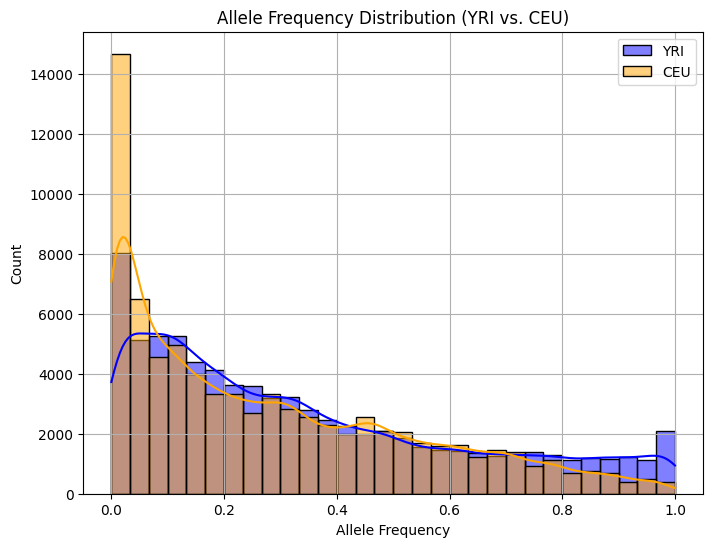

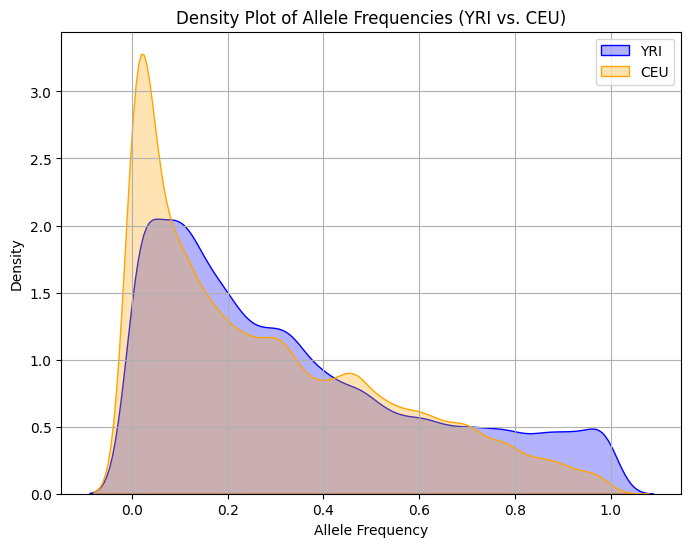

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed results
df = pd.read_csv('/content/drive/MyDrive/significant_snps_with_populations.csv')

# Scatter Plot: YRI vs. CEU Allele Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['YRI_AF'], y=df['CEU_AF'], alpha=0.5)
plt.xlabel('YRI Allele Frequency')
plt.ylabel('CEU Allele Frequency')
plt.title('Allele Frequency Comparison: YRI vs. CEU')
plt.axline((0, 0), slope=1, color='red', linestyle='--')  # Diagonal reference line
plt.grid(True)
plt.show()

# Histogram: Distribution of Allele Frequencies
plt.figure(figsize=(8, 6))
sns.histplot(df['YRI_AF'], bins=30, alpha=0.5, label='YRI', color='blue', kde=True)
sns.histplot(df['CEU_AF'], bins=30, alpha=0.5, label='CEU', color='orange', kde=True)
plt.xlabel('Allele Frequency')
plt.ylabel('Count')
plt.title('Allele Frequency Distribution (YRI vs. CEU)')
plt.legend()
plt.grid(True)
plt.show()

# Density Plot: Highlighting Distribution Differences
plt.figure(figsize=(8, 6))
sns.kdeplot(df['YRI_AF'], label='YRI', fill=True, color='blue', alpha=0.3)
sns.kdeplot(df['CEU_AF'], label='CEU', fill=True, color='orange', alpha=0.3)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Density Plot of Allele Frequencies (YRI vs. CEU)')
plt.legend()
plt.grid(True)
plt.show()

##11. Highlight Outliers, such as SNPs with extreme differences

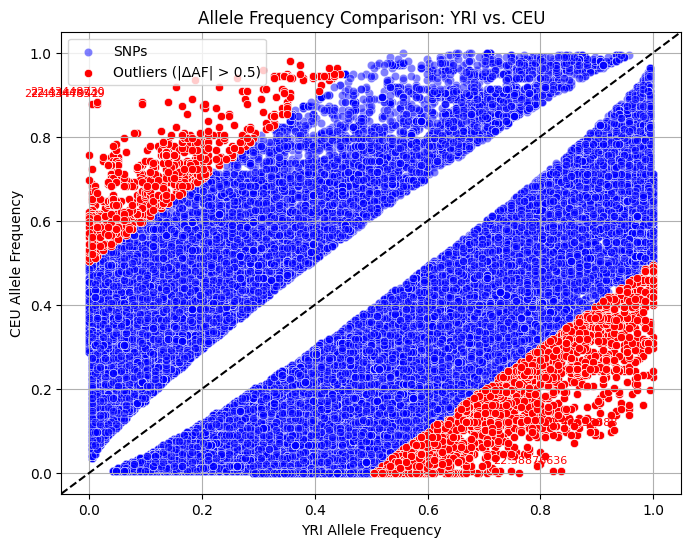

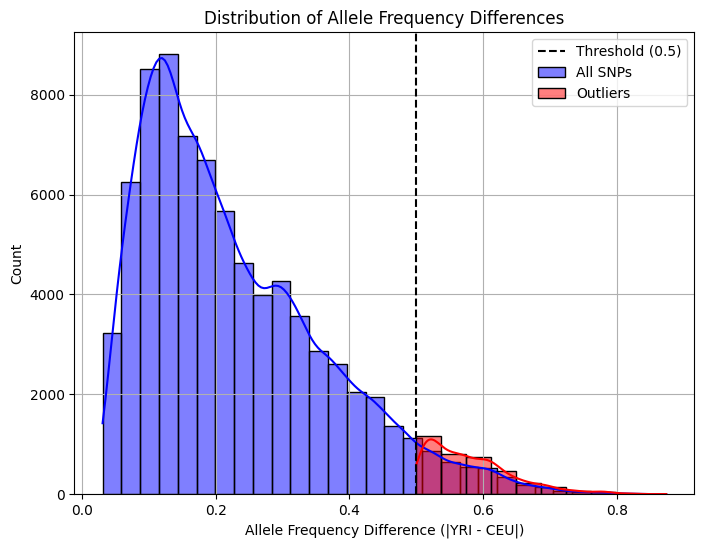

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the processed results
df = pd.read_csv('/content/drive/MyDrive/significant_snps_with_populations.csv')

# Compute absolute differences
df['AF_Difference'] = abs(df['YRI_AF'] - df['CEU_AF'])

# Define outlier threshold (adjust if needed)
threshold = 0.5
outliers = df[df['AF_Difference'] > threshold]

# Scatter Plot: Highlighting Outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['YRI_AF'], y=df['CEU_AF'], alpha=0.5, label='SNPs', color='blue')
sns.scatterplot(x=outliers['YRI_AF'], y=outliers['CEU_AF'], color='red', label='Outliers (|ΔAF| > 0.5)')
plt.xlabel('YRI Allele Frequency')
plt.ylabel('CEU Allele Frequency')
plt.title('Allele Frequency Comparison: YRI vs. CEU')
plt.axline((0, 0), slope=1, color='black', linestyle='--')  # Diagonal reference line
plt.legend()
plt.grid(True)

# Annotate top 5 extreme outliers
for i, row in outliers.nlargest(5, 'AF_Difference').iterrows():
    chrom_pos = f"{str(row['CHROM'])}:{str(row['POS'])}"  # Ensure string format
    plt.annotate(chrom_pos,
                 (row['YRI_AF'], row['CEU_AF']),
                 textcoords="offset points",
                 xytext=(5,5),
                 ha='right', fontsize=8, color='red')


plt.show()

# Histogram with Outlier Highlights
plt.figure(figsize=(8, 6))
sns.histplot(df['AF_Difference'], bins=30, kde=True, color='blue', label='All SNPs')
sns.histplot(outliers['AF_Difference'], bins=10, kde=True, color='red', label='Outliers')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold (0.5)')
plt.xlabel('Allele Frequency Difference (|YRI - CEU|)')
plt.ylabel('Count')
plt.title('Distribution of Allele Frequency Differences')
plt.legend()
plt.grid(True)
plt.show()


1st figure:
🔹 Outliers (Extreme SNPs) are highlighted in red on the scatter plot.
🔹 Threshold for outliers: Any SNP where |YRI_AF - CEU_AF| > 0.5 (you can adjust this).
🔹 Labels are added to the most extreme SNPs.

2nd figure
 Explanation of the Plot:

    X-Axis: "Allele Frequency Difference (|YRI - CEU|)"
        This represents the absolute difference in allele frequencies between the two populations.
        The values range from 0 to ~0.8, where 0 means no difference and higher values indicate greater genetic differentiation.

    Y-Axis: "Count"
        This shows how many SNPs (Single Nucleotide Polymorphisms) fall into each range of frequency difference.

    Histogram Bars (Blue)
        The blue bars show the distribution of all SNPs based on their allele frequency differences.
        Most SNPs have small differences (peaking around 0.1-0.2), meaning the two populations share similar allele frequencies for most genetic variants.

    Threshold Line (Black, Dashed)
        A black dashed line at 0.5 represents a significance threshold.
        SNPs with allele frequency differences above this line are considered outliers—these are positions where allele frequencies differ greatly between YRI and CEU.

    Outliers (Red)
        SNPs with allele frequency differences greater than 0.5 are highlighted in red.
        These SNPs represent genetic variants that are highly differentiated between YRI and CEU, possibly due to natural selection, genetic drift, or population-specific mutations.